In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
from deep_translator import GoogleTranslator

from tqdm import tqdm

plt.style.use('ggplot')

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from google_play_scraper import Sort, reviews, app

KeyboardInterrupt: 

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/raycalm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
apps_ids = ['br.com.brainweb.ifood', 'com.cerveceriamodelo.modelonow',

'com.mcdo.mcdonalds', 'habibs.alphacode.com.br',

'com.ubercab.eats', 'com.grability.rappi',

'burgerking.com.br.appandroid', 

'com.vanuatu.aiqfome',

'br.com.sbf.centauro',

'br.com.riachuelo.app',

'com.mercadolibre',

'com.cerveceriamodelo.modelonow',

'com.amazon.mShop.android.shopping',

'br.gov.meugovbr',

'com.b2w.americanas',

'br.com.lojasrenner',

'br.com.marisa.android',

'com.zzkko',

'com.luizalabs.mlapp']

In [ ]:
apps_reviews = []

for ap in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='pt',
                country='br',
                sort=sort_order,
                count= 200 if score == 3 else 100,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            apps_reviews.extend(rvs)

100%|██████████| 19/19 [01:16<00:00,  4.05s/it]


In [ ]:
df = pd.DataFrame(apps_reviews)

In [ ]:
df = df.drop(['reviewId'], axis=1)
df['id'] = range(1, len(df) + 1)

In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
0,Fabiano Porto,https://play-lh.googleusercontent.com/a-/ALV-U...,Já é a segunda vez que tento resolver um probl...,1,28,10.24.0,2024-07-14 15:24:26,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,1
1,Guilherme Gomes,https://play-lh.googleusercontent.com/a/ACg8oc...,Um lixo de aplicativo. Cada vez mais a experiê...,1,34,10.24.0,2024-07-08 17:11:27,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,2
2,Guidi Yu,https://play-lh.googleusercontent.com/a-/ALV-U...,O atendimento pelo chat no geral era bom. Hoje...,1,30,10.24.0,2024-07-05 21:21:42,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,3
3,Luis Martins,https://play-lh.googleusercontent.com/a/ACg8oc...,Estou bem decepcionado com o app. É cada vez m...,1,3,10.24.0,2024-07-13 17:02:54,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,4
4,Igor Fernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,"Com certeza um dos piores apps que tenho, volu...",1,69,10.24.0,2024-07-04 19:58:07,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,5


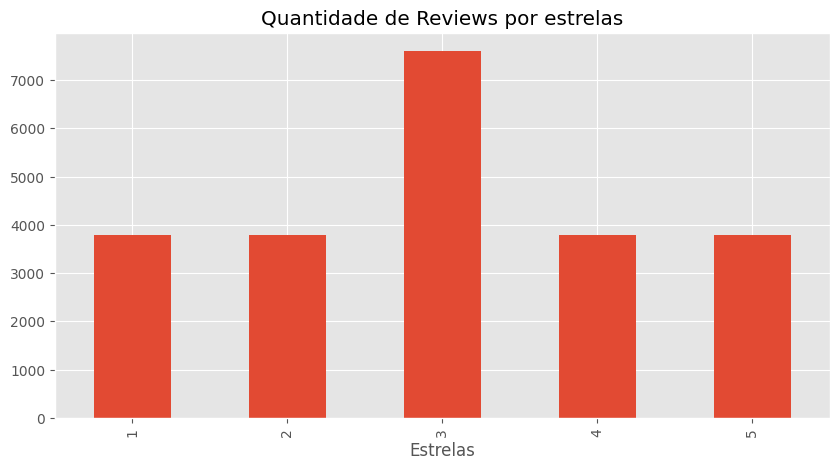

In [ ]:
ax = df['score'].value_counts().sort_index().plot(kind='bar', title='Quantidade de Reviews por estrelas', figsize=(10, 5))
ax.set_xlabel('Estrelas')
plt.show()

### NLTK Básico

In [ ]:
WORD_MIN_LENGTH = 2
STOP_WORDS_PT = [stop_word.lower() for stop_word in nltk.corpus.stopwords.words('portuguese')]
spell = SpellChecker(language='pt')

def strip_accents(text):
    nfkd = unicodedata.normalize('NFKD', text)
    stripped_text = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    return re.sub('[^a-zA-Z]', ' ', stripped_text)

def tokenize(text):
    text = strip_accents(text)
    text = re.sub(re.compile('\n'),' ',text)
    words = word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if word not in STOP_WORDS_PT and len(word) >= WORD_MIN_LENGTH]
    return words

def lemmatize(text):
    lemmatized_text = []
    for (word) in text:
        lemmatizing = str(WordNetLemmatizer().lemmatize(word))
        lemmatized_text.append(lemmatizing)
    return lemmatized_text

def preprocess_stl(array):
    preprocessed = []

    stripped_rvs = [strip_accents(rvs) for rvs in array]
    tokenized_rvs = [tokenize(rvs) for rvs in stripped_rvs]
    lemmatized_rvs = [lemmatize(rvs) for rvs in tokenized_rvs]

    preprocessed = lemmatized_rvs

    return preprocessed



## Utilizando VADER
Abordagem BoW - removeremos stop words e cada palavra remeterá a uma pontuação e essas pontuações serão combinadas para obter uma pontuação final

In [ ]:
sia = SentimentIntensityAnalyzer()
translator = GoogleTranslator(source='pt', target='en')

In [ ]:
def translate_and_analyze(text, myid):
    try:
        translated_text = translator.translate(text)
        if translated_text is None:
            raise ValueError("Translation returned None")
        sentiment = sia.polarity_scores(translated_text)
        return myid, sentiment
    except Exception as e:
        return myid, {"error": str(e)}

In [ ]:
df_sample = df.sample(n=1000, random_state=42)

res = {}
for index, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    myid, sentiment = translate_and_analyze(row['content'], row['id'])
    res[myid] = sentiment

100%|██████████| 1000/1000 [22:43<00:00,  1.36s/it]


In [ ]:
df_sample.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
3165,Luana Lamb,https://play-lh.googleusercontent.com/a/ACg8oc...,Não entregaram um MC lanche feliz e eu tive qu...,3,2,3.41.1,2024-03-10 19:39:55,None,NaT,3.41.1,newest,com.mcdo.mcdonalds,3166
13108,Edson Sousa Porto,https://play-lh.googleusercontent.com/a/ACg8oc...,Voces sao Honestos.amei,5,0,10.339.1,2024-07-15 19:50:35,None,NaT,10.339.1,newest,com.mercadolibre,13109
12288,Ezequiel Alves,https://play-lh.googleusercontent.com/a-/ALV-U...,Ultimamente a interface do mercado livre está ...,2,59,10.331.0,2024-06-20 09:27:48,None,NaT,10.331.0,most_relevant,com.mercadolibre,12289
2222,Ricardes Carneiro,https://play-lh.googleusercontent.com/a/ACg8oc...,Preço top. A entrega foi rápida e eficiente. A...,5,1,24.17.1,2024-06-16 00:14:48,None,NaT,24.17.1,most_relevant,com.cerveceriamodelo.modelonow,2223
22767,Claudir Marques,https://play-lh.googleusercontent.com/a-/ALV-U...,Otimo,5,0,5.7.0,2024-07-13 16:35:31,"Oi, Claudir. Fico feliz em saber disso! Sua sa...",2024-07-15 08:45:37,5.7.0,newest,com.luizalabs.mlapp,22768


In [ ]:
vaders = pd.DataFrame(res).T
vaders.reset_index(inplace=True)
vaders = vaders.rename(columns={'index': 'id'})
vaders = vaders.merge(df_sample, how='left', on='id')

In [ ]:
vaders = vaders.drop(['userImage', 'reviewCreatedVersion', 'replyContent', 'sortOrder', 'thumbsUpCount', 'at', 'repliedAt', 'appVersion', 'userName'], axis=1)

In [ ]:
vaders.head()

,id,neg,neu,pos,compound,error,content,score,appId
0,3166,0.179,0.785,0.036,-0.7056,NaN,Não entregaram um MC lanche feliz e eu tive qu...,3,com.mcdo.mcdonalds
1,13109,0.0,0.294,0.706,0.802,NaN,Voces sao Honestos.amei,5,com.mercadolibre
2,12289,0.039,0.806,0.155,0.8424,NaN,Ultimamente a interface do mercado livre está ...,2,com.mercadolibre
3,2223,0.0,0.593,0.407,0.8519,NaN,Preço top. A entrega foi rápida e eficiente. A...,5,com.cerveceriamodelo.modelonow
4,22768,0.0,0.0,1.0,0.5719,NaN,Otimo,5,com.luizalabs.mlapp


In [ ]:
vaders = vaders.dropna(subset=['pos', 'neg', 'neu'])

In [ ]:
vaders[vaders['error'].notna()]

,id,neg,neu,pos,compound,error,content,score,appId


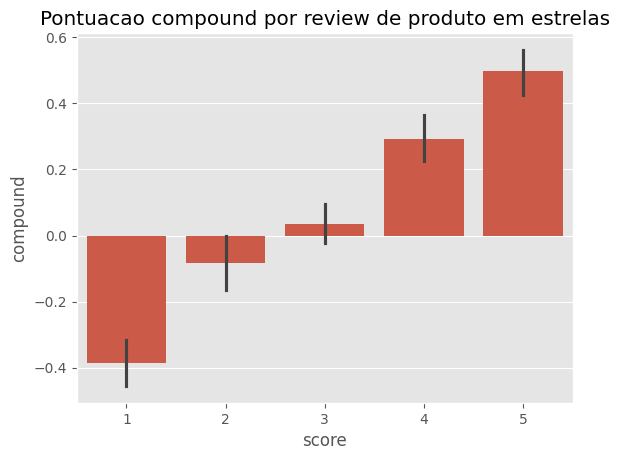

In [ ]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Pontuacao compound por review de produto em estrelas')
plt.show()

Quando menor a pontuação compound, menor a quantidade de estrelas dada pelo consumidor.

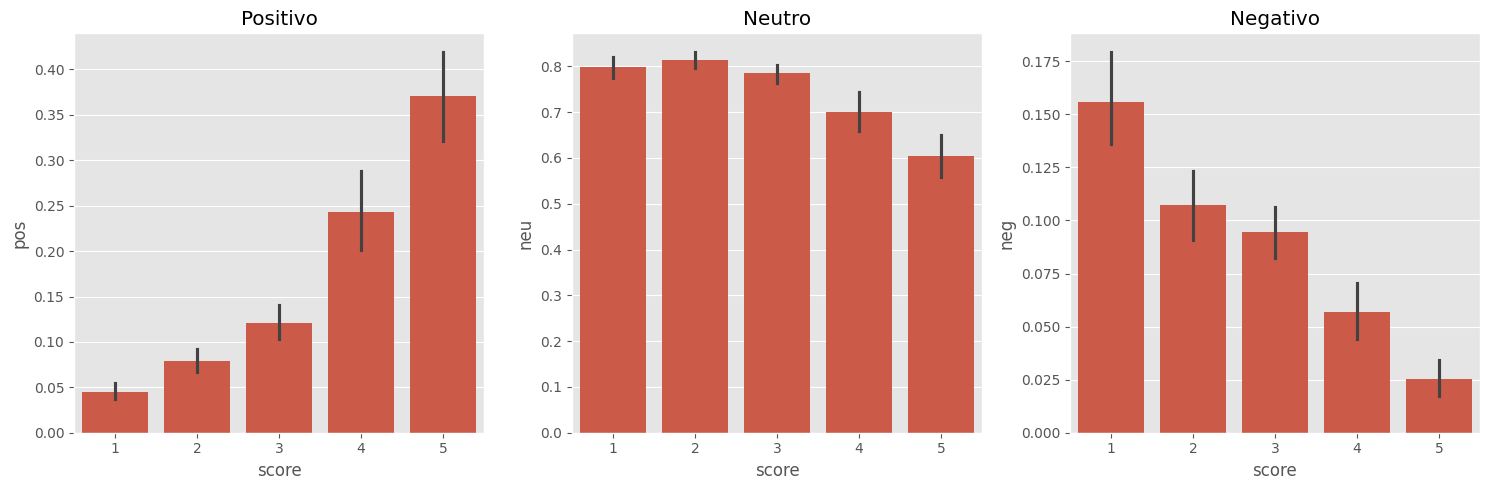

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])

axs[0].set_title('Positivo')
axs[1].set_title('Neutro')
axs[2].set_title('Negativo')

plt.tight_layout()
plt.show()

## Utilizando BERT

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]